# Assignment 3 - Building a Custom Visualization

---

In this assignment you must choose one of the options presented below and submit a visual as well as your source code for peer grading. The details of how you solve the assignment are up to you, although your assignment must use matplotlib so that your peers can evaluate your work. The options differ in challenge level, but there are no grades associated with the challenge level you chose. However, your peers will be asked to ensure you at least met a minimum quality for a given technique in order to pass. Implement the technique fully (or exceed it!) and you should be able to earn full grades for the assignment.


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Ferreira, N., Fisher, D., & Konig, A. C. (2014, April). [Sample-oriented task-driven visualizations: allowing users to make better, more confident decisions.](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/Ferreira_Fisher_Sample_Oriented_Tasks.pdf) 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In Proceedings of the SIGCHI Conference on Human Factors in Computing Systems (pp. 571-580). ACM. ([video](https://www.youtube.com/watch?v=BI7GAs-va-Q))


In this [paper](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/Ferreira_Fisher_Sample_Oriented_Tasks.pdf) the authors describe the challenges users face when trying to make judgements about probabilistic data generated through samples. As an example, they look at a bar chart of four years of data (replicated below in Figure 1). Each year has a y-axis value, which is derived from a sample of a larger dataset. For instance, the first value might be the number votes in a given district or riding for 1992, with the average being around 33,000. On top of this is plotted the 95% confidence interval for the mean (see the boxplot lectures for more information, and the yerr parameter of barcharts).

<br>
<img src="readonly/Assignment3Fig1.png" alt="Figure 1" style="width: 400px;"/>
<h4 style="text-align: center;" markdown="1">  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Figure 1 from (Ferreira et al, 2014).</h4>

<br>

A challenge that users face is that, for a given y-axis value (e.g. 42,000), it is difficult to know which x-axis values are most likely to be representative, because the confidence levels overlap and their distributions are different (the lengths of the confidence interval bars are unequal). One of the solutions the authors propose for this problem (Figure 2c) is to allow users to indicate the y-axis value of interest (e.g. 42,000) and then draw a horizontal line and color bars based on this value. So bars might be colored red if they are definitely above this value (given the confidence interval), blue if they are definitely below this value, or white if they contain this value.


<br>
<img src="readonly/Assignment3Fig2c.png" alt="Figure 1" style="width: 400px;"/>
<h4 style="text-align: center;" markdown="1">  Figure 2c from (Ferreira et al. 2014). Note that the colorbar legend at the bottom as well as the arrows are not required in the assignment descriptions below.</h4>

<br>
<br>

**Easiest option:** Implement the bar coloring as described above - a color scale with only three colors, (e.g. blue, white, and red). Assume the user provides the y axis value of interest as a parameter or variable.


**Harder option:** Implement the bar coloring as described in the paper, where the color of the bar is actually based on the amount of data covered (e.g. a gradient ranging from dark blue for the distribution being certainly below this y-axis, to white if the value is certainly contained, to dark red if the value is certainly not contained as the distribution is above the axis).

**Even Harder option:** Add interactivity to the above, which allows the user to click on the y axis to set the value of interest. The bar colors should change with respect to what value the user has selected.

**Hardest option:** Allow the user to interactively set a range of y values they are interested in, and recolor based on this (e.g. a y-axis band, see the paper for more details).

---

*Note: The data given for this assignment is not the same as the data used in the article and as a result the visualizations may look a little different.*

In [1]:
# Use the following data for this assignment:
import pandas as pd
import numpy as np

np.random.seed(12345)

df = pd.DataFrame([np.random.normal(32000, 200000, 3650), 
                   np.random.normal(43000, 100000, 3650), 
                   np.random.normal(43500, 140000, 3650), 
                   np.random.normal(48000, 70000, 3650)], 
                  index=[1992, 1993, 1994, 1995])
df.T.describe()

,1992,1993,1994,1995
count,3650.000000,3650.000000,3650.000000,3650.000000
mean,33312.107476,41861.859541,39493.304941,47743.550969
std,200630.901553,98398.356203,140369.925240,69781.185469
min,-717071.175466,-321586.023683,-450827.613097,-189865.963265
25%,-102740.398364,-26628.302213,-57436.397393,1774.555612
50%,29674.931050,43001.976658,41396.781369,49404.322978
75%,167441.838695,108296.577923,137261.713785,94164.333867
max,817505.608159,395586.505068,490091.665037,320826.888044


In [2]:
# Import essential libraries
import scipy.stats as st

# Add mean and standard deviation columns
df['mean']=df.mean(axis=1)
df['std']=df.std(axis=1)

# Add interval and y error bar columns
df['i_min'], df['i_max']=st.t.interval(0.95,
                                       len(df.count(axis=1))-1,
                                       loc=df.mean(axis=1),
                                       scale=df.sem(axis=1))
df['yerr'] = (df['i_max'].abs() - df['i_min'].abs())

 
df[['mean', 'i_min', 'i_max', 'yerr', 'std']]

,mean,i_min,i_max,yerr,std
1992,33312.107476,22794.219493,43921.611728,21127.392235,200603.415985
1993,41861.859541,36696.687580,47057.986057,10361.298477,98384.876053
1994,39493.304941,32130.291375,46911.552566,14781.261192,140350.695166
1995,47743.550969,44075.736419,51423.429087,7347.692668,69771.625748


<IPython.core.display.Javascript object>


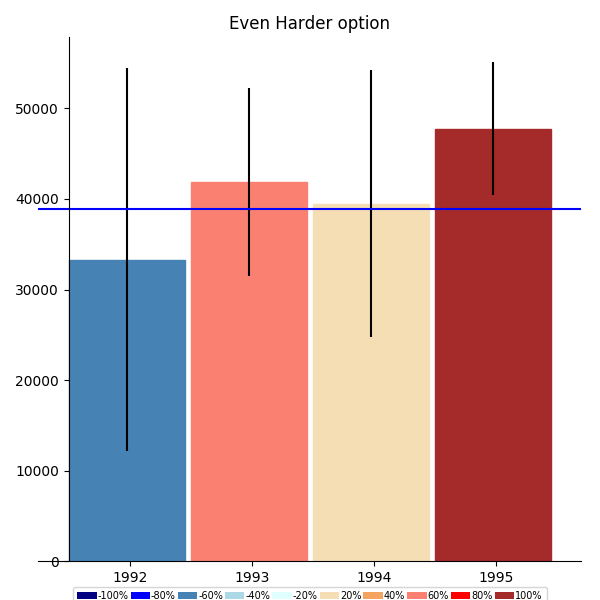

7

In [3]:
# Import essential libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Rectangle
from collections import OrderedDict
%matplotlib notebook

# Create a legend dictionary
dct=OrderedDict( [('navy','-100%'), ('blue','-80%'), ('steelblue','-60%'), ('lightblue','-40%'), 
                ('lightcyan','-20%'), ('wheat','20%'), ('sandybrown','40%'), 
                ('salmon','60%'), ('red','80%'), ('brown','100%')] )
cl_max_color='red'
cl_min_color='blue'
cl_neutral_color='grey'

com_alpha=0.7

class Cursor(object):
    _df=None
    _bl=None
    def __init__(self, ax, data_F, bars):
        self._df=data_F
        self._bl=bars
        self.ax = ax
        self.lx = ax.axhline(color='b')

    def mouse_move(self, event):
        if not event.inaxes:
            return
        x, y = event.xdata, event.ydata
        self.lx.set_ydata(y)
        for index, row in self._df.iterrows():
            if row['i_max']<y:
                self._bl[self._df.index.get_loc(index)].set_color(cl_min_color)
                continue
            if row['i_min']>y:
                self._bl[self._df.index.get_loc(index)].set_color(cl_max_color)
                continue
            
            self._bl[self._df.index.get_loc(index)].set_color(cl_neutral_color)
        plt.draw()

class CursorHard(Cursor):
    _colors=list(reversed(dct.keys()))
    _num_bins=8
    def _get_color(self, d_series, val):
        s=d_series[['i_min', 'i_max']]
        s['val']=val
        s=pd.cut(s, bins=self._num_bins, labels=list(range(self._num_bins)), include_lowest=False, right=True)
        return self._colors[s['val']+1]

    def mouse_move(self, event):
        if not event.inaxes:
            return
        x, y = event.xdata, event.ydata
        self.lx.set_ydata(y)
        for index, row in self._df.iterrows():
            if row['i_max']<y:
                self._bl[self._df.index.get_loc(index)].set_color(self._colors[-1])
                continue
            if row['i_min']>y:
                self._bl[self._df.index.get_loc(index)].set_color(self._colors[0])
                continue
            
            self._bl[self._df.index.get_loc(index)].set_color(self._get_color(row, y))
        plt.draw()
        
def plot_base(fix_x, fig_y, fig_title, c_alpha=0.5):
    ax=df['mean'].plot.bar(yerr=df['yerr'], 
        title =fig_title, figsize=(fix_x, fig_y), 
        legend=False, fontsize=10, alpha=c_alpha, width=0.95, 
        rot=0, position=0, style='-', color=cl_neutral_color)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')

    majors = [0.5, 1.5, 2.5, 3.5]
    ax.xaxis.set_major_locator(ticker.FixedLocator(majors))

    plt.tight_layout()
    
    return (ax, ax.get_children()[1:5])

ax1, barlist1=plot_base(6, 6, 'Even Harder option', c_alpha=1) 

bars_leg=[]

for k, v in dct.items():
    p=Rectangle((0, 0), 1, 1, fc=k, label=v)
    bars_leg.append(p)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.04), 
           handles=bars_leg, ncol=len(bars_leg), columnspacing=0.2, handletextpad=0.1, fontsize=7)

plt.tight_layout()
plt.show()

hcursor = CursorHard(ax1, df, barlist1)
plt.connect('motion_notify_event', hcursor.mouse_move)

In [5]:
plt.savefig('assignment3.png')